In [ ]:
!pip install yfinance xgboost catboost matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import yfinance as yf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2010-01-04  1132.989990  1132.989990  1133.869995  1116.560059  1116.560059   
2010-01-05  1136.520020  1136.520020  1136.630005  1129.660034  1132.660034   
2010-01-06  1137.140015  1137.140015  1139.189941  1133.949951  1135.709961   
2010-01-07  1141.689941  1141.689941  1142.459961  1131.319946  1136.270020   
2010-01-08  1144.979980  1144.979980  1145.390015  1136.219971  1140.520020   
...                 ...          ...          ...          ...          ...   
2024-12-06  6090.270020  6090.270020  6099.970215  6079.979980  6081.379883   
2024-12-09  6052.850098  6052.850098  6088.509766  6048.629883  6083.009766   
2024-12-10  6034.910156  6034.910156  6065.399902  6029.890137  6057.589844   
2024-12-11  6084.18994

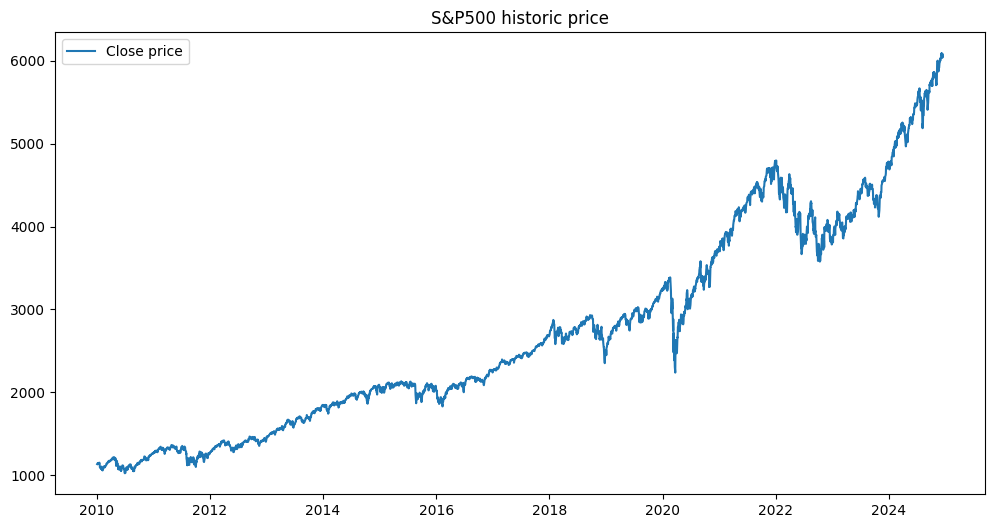

In [ ]:
ticker = "^GSPC"
start_date = "2010-01-01"
end_date = "2024-12-13"

df = yf.download(ticker, start=start_date, end=end_date)
print(df.head)

plt.figure(figsize=(12,6))
plt.plot(df["Close"], label = "Close price")
plt.title("S&P500 historic price")
plt.legend()
plt.show()

In [ ]:
data = df[["Close"]]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length])
  return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_test: {X_test.shape}")

Size of X_train: (2961, 60, 1)
Size of X_test: (741, 60, 1)


In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
y_pred_lr = lr_model.predict(X_test_flat)

xgb_model = XGBRegressor()
xgb_model.fit(X_train_flat, y_train)
y_pred_xgb = xgb_model.predict(X_test_flat)

cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train_flat, y_train)
y_pred_cat = cat_model.predict(X_test_flat)

def evaluate_model(y_true, y_pred, model_name):
  mse = mean_squared_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  print(f"{model_name} -> MSE: {mse:.4f}, R2: {r2:.4f}")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_cat, "CatBoost")

Linear Regression -> MSE: 0.0001, R2: 0.9940
XGBoost -> MSE: 0.0070, R2: 0.5662
CatBoost -> MSE: 0.0075, R2: 0.5319


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0113 - val_loss: 5.5623e-04
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 9.7437e-04 - val_loss: 8.6908e-04
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 8.5605e-04 - val_loss: 5.3956e-04
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 8.5285e-04 - val_loss: 5.9173e-04
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 7.1502e-04 - val_loss: 7.1875e-04
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 7.5014e-04 - val_loss: 6.5828e-04
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 6.9249e-04 - val_loss: 7.2856e-04
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 6.2214e-04 - val_loss: 9.0692e-04
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 5.6549e-04 - val_loss: 4.9023e-04
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 5.6753e-04 - val_loss: 4.9824e-04
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 4.9696e-

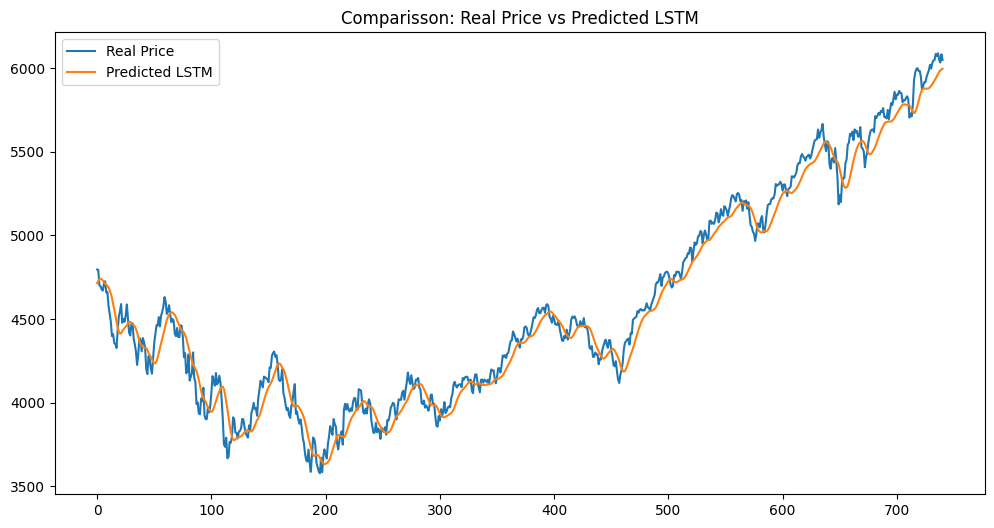

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred_lstm = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Real Price")
plt.plot(y_pred_lstm_inv, label="Predicted LSTM")
plt.title("Comparisson: Real Price vs Predicted LSTM")
plt.legend()
plt.show()

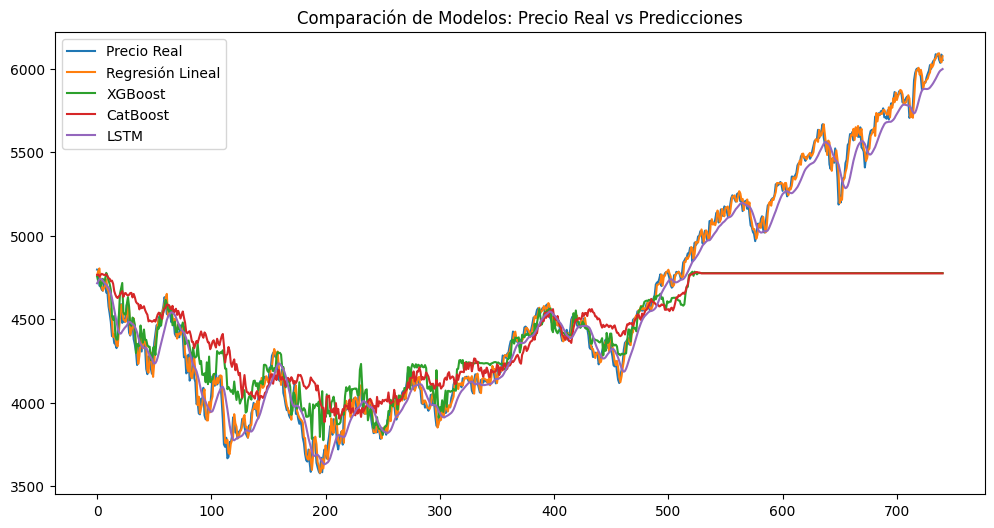

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Precio Real")
plt.plot(scaler.inverse_transform(y_pred_lr.reshape(-1, 1)), label="Regresión Lineal")
plt.plot(scaler.inverse_transform(y_pred_xgb.reshape(-1, 1)), label="XGBoost")
plt.plot(scaler.inverse_transform(y_pred_cat.reshape(-1, 1)), label="CatBoost")
plt.plot(y_pred_lstm_inv, label="LSTM")
plt.title("Comparación de Modelos: Precio Real vs Predicciones")
plt.legend()
plt.show()